Importation des modules et des données

In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
 96% 299M/312M [00:03<00:00, 152MB/s]
100% 312M/312M [00:03<00:00, 97.5MB/s]


In [ ]:
!unzip brain-tumor-segmentation.zip -d /content/brain_tumors

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/brain_tumors/images/2013.png  
  inflating: /content/brain_tumors/images/2014.png  
  inflating: /content/brain_tumors/images/2015.png  
  inflating: /content/brain_tumors/images/2016.png  
  inflating: /content/brain_tumors/images/2017.png  
  inflating: /content/brain_tumors/images/2018.png  
  inflating: /content/brain_tumors/images/2019.png  
  inflating: /content/brain_tumors/images/202.png  
  inflating: /content/brain_tumors/images/2020.png  
  inflating: /content/brain_tumors/images/2021.png  
  inflating: /content/brain_tumors/images/2022.png  
  inflating: /content/brain_tumors/images/2023.png  
  inflating: /content/brain_tumors/images/2024.png  
  inflating: /content/brain_tumors/images/2025.png  
  inflating: /content/brain_tumors/images/2026.png  
  inflating: /content/brain_tumors/images/2027.png  
  inflating: /content/brain_tumors/images/2028.png  
  inflating: /content/

In [ ]:
#Importation des bibliothèques pour le traitement des données (numpy, cv2),
#la création d'un modèle (TensorFlow/Keras) et la division des données (scikit-learn).
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import cv2

In [ ]:
import os
print(os.listdir("brain_tumors"))


['images', 'masks']


In [ ]:
#Définit les chemins des images et masques du dataset.
DATASET_PATH = "brain_tumors"
IMAGES_PATH = os.path.join(DATASET_PATH, "images")
MASKS_PATH = os.path.join(DATASET_PATH, "masks")


In [ ]:
# Paramètres globaux
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Taille des images redimensionnées
#Taille de lot (batch size = 16) :  le modèle traite 16 images à la fois
BATCH_SIZE = 16
#Nombre d'époques (epochs = 20) : Le modèle passe 20 fois sur toutes les données pour affiner ses prédictions.
EPOCHS = 20

In [ ]:
# Chargement et prétraitement des données
def load_data(images_path, masks_path):
    images = []
    masks = []

    for filename in os.listdir(images_path): #Liste tous les fichiers dans le répertoire spécifié par images_path
        img = cv2.imread(os.path.join(images_path, filename), cv2.IMREAD_COLOR) #cv2.imread permet de lire une image en tableau numpy et cv2.IMREAD_COLOR charge l'image en mode couleur (RGB)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) #Redimensionne l'image lue pour qu'elle ait une taille standardisée
        images.append(img / 255.0)  # Divise chaque valeur de pixel par 255 pour les normaliser entre 0 et 1.

        #le meme chose pour le mask
        mask = cv2.imread(os.path.join(masks_path, filename), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        masks.append(mask / 255.0)

    return np.array(images), np.array(masks).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1) #Retourne deux tableaux NumPy :Contient les images et masks normalisées.

images, masks = load_data(IMAGES_PATH, MASKS_PATH)


In [ ]:
# Division des données
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Modèle U-Net
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs) #Applique 64 filtres convolutionnels de taille 3x3./ activation='relu' introduit la non-linéarité./ padding='same' garantit que la taille de sortie est identique à celle d'entrée.
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  #Réduit la taille de l'image d'entrée de moitié (ex. 128x128 → 64x64)

    #Les étapes suivantes répètent ce schéma avec des filtres de plus en plus nombreux (plus de filtres = capacité d'extraire des caractéristiques complexes).
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
  # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4) #Restaure la taille originale des images
    merge5 = concatenate([conv3, up5], axis=3)#Fusionne les caractéristiques encodées
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)#sigmoid est idéale pour des tâches de segmentation binaire, où chaque pixel est soit dans la classe cible (1) soit dans l'arrière-plan (0).

    model = Model(inputs, outputs) #Crée un objet Model de Keras, qui représente le réseau de neurones complet.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
#Initialise le modèle U-Net et affiche un résumé.
model = unet_model()
model.summary()

#Entraîne le modèle
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 512)    │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 768)    │              0 │ conv2d_5[0][0],        │
│                           │                        │                │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 256)    │      1,769,728 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 64, 64, 256)    │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)       

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 92s 394ms/step - accuracy: 0.9626 - loss: 0.1825 - val_accuracy: 0.9828 - val_loss: 0.0632
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 177ms/step - accuracy: 0.9823 - loss: 0.0633 - val_accuracy: 0.9828 - val_loss: 0.0569
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.9827 - loss: 0.0534 - val_accuracy: 0.9841 - val_loss: 0.0506
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.9830 - loss: 0.0588 - val_accuracy: 0.9857 - val_loss: 0.0459
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.9855 - loss: 0.0436 - val_accuracy: 0.9860 - val_loss: 0.0486
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 42s 177ms/step - accuracy: 0.9859 - loss: 0.0401 - val_accuracy: 0.9875 - val_loss: 0.0347
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 26s 172ms/step - accuracy: 0.9878 - loss: 0.0330 - val_accuracy: 0.9866 - val_loss: 0.0368
Epoch 8/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.9888 - loss: 0

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9922 - loss: 0.0209


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step


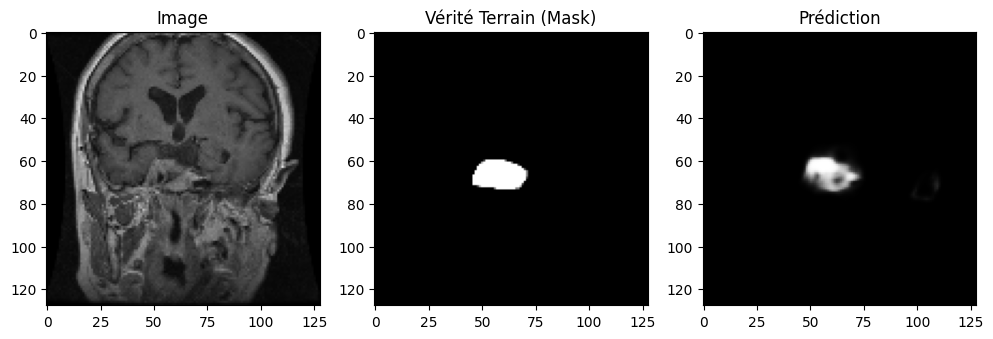

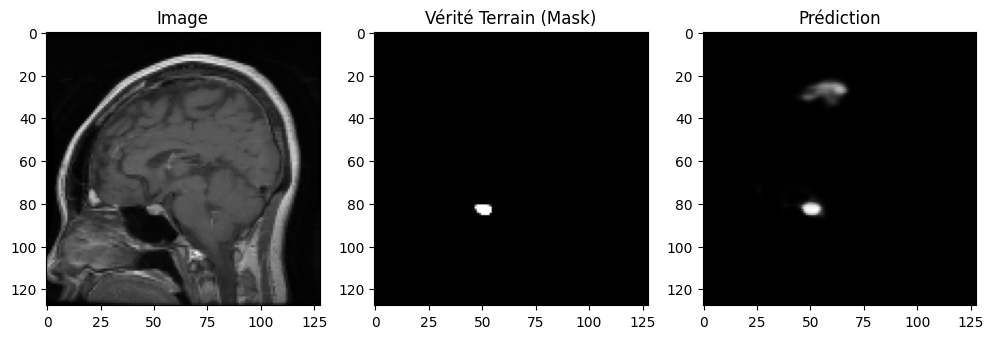

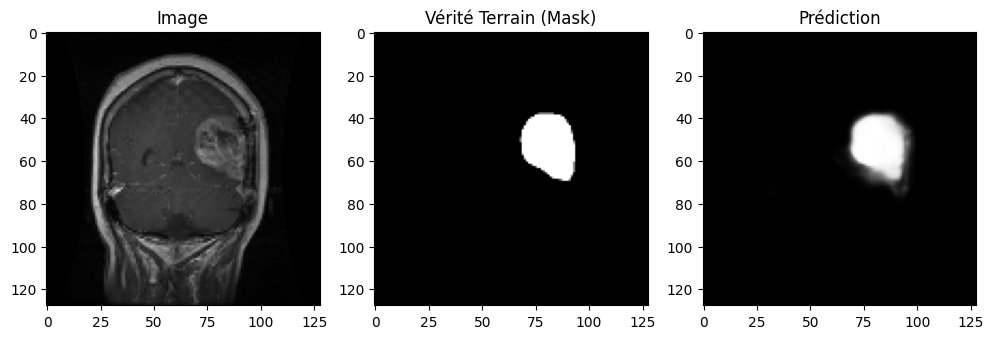

In [ ]:
# Évaluation et sauvegarde du modèle
model.evaluate(x_val, y_val)
model.save("brain_tumor_segmentation_unet.h5")

# Visualisation des résultats
#affiche les résultats de segmentation en comparant les images d'entrée, les masques réels et les prédictions du modèle pour un nombre spécifié d'échantillons (3 par défaut).
def plot_predictions(images, masks, predictions, num_samples=3):
    import matplotlib.pyplot as plt

    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(images[i])

        plt.subplot(1, 3, 2)
        plt.title("Vérité Terrain (Mask)")
        plt.imshow(masks[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Prédiction")
        plt.imshow(predictions[i].squeeze(), cmap='gray')

        plt.show()

predictions = model.predict(x_val)
plot_predictions(x_val, y_val, predictions)


In [ ]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

Saving tumor4.jpg to tumor4.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


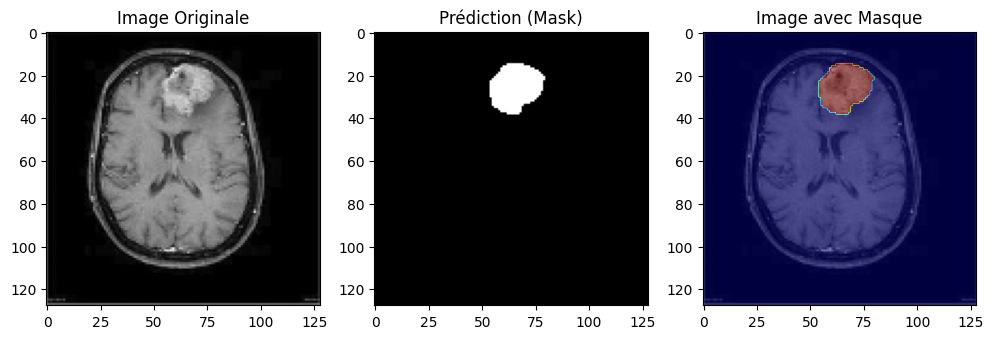

In [ ]:
# Fonction pour évaluer une image unique externe
def evaluate_single_image(image_path, model):
    import matplotlib.pyplot as plt

    # Charger l'image et vérifier si elle existe
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"L'image n'a pas été trouvée au chemin : {image_path}")

    # Prétraitement de l'image
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img_normalized = img_resized / 255.0
    img_input = np.expand_dims(img_normalized, axis=0)  # La fonction np.expand_dims ajoute une dimension batch à l'image img_normalized pour la rendre compatible avec le modèle, qui attend des données sous forme de lots, même si une seule image est traitée.

    # Prédire le masque
    predicted_mask = model.predict(img_input)[0]  # Obtenir le premier (et unique) résultat
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # predicted_mask > 0.5 applique un seuil de 0.5 sur les prédictions du modèle . Ensuite, .astype(np.uint8) convertit ces valeurs booléennes (True/False) en entiers de 8 bits (1/0), ce qui rend la carte de segmentation compatible avec les opérations d'affichage ou d'enregistrement d'images.

    # Afficher les résultats
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Image Originale")
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 3, 2)
    plt.title("Prédiction (Mask)")
    plt.imshow(predicted_mask.squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Image avec Masque")
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    plt.imshow(predicted_mask.squeeze(), cmap='jet', alpha=0.5)

    plt.show()

# Chemin vers une image externe
local_image_path = "/content/tumor4.jpg"  # Remplacez par le chemin réel
evaluate_single_image(local_image_path, model)
